## LangGraph SQL Agent 中文指南

本指南详细展示了如何构建一个能够回答关于 SQL 数据库问题的 Agent，结合了 LangGraph、LangChain 和 OpenAI 的能力，能够处理复杂的 SQL 查询并提供智能化的交互式响应。

### 总体流程

Agent 将执行以下任务：
1. 获取数据库中的可用表。
2. 判断哪些表与问题相关。
3. 获取相关表的 DDL（数据定义语言）。
4. 根据问题和 DDL 信息生成 SQL Query
5. 使用 LLM（大语言模型）检查 SQL Query 中的常见错误。
6. 执行查询并返回结果。
7. 如果数据库引擎返回错误，纠正查询中的错误，直到查询成功。
8. 根据查询结果生成最终回答。

### 完整的工作流程如下：

### 环境配置
首先，我们将配置 OpenAI 和可选的 LangSmith API 环境变量，并启用 LangSmith 的追踪功能。



In [1]:
import os

# 设置 API 密钥和 LangSmith 追踪功能
os.environ["LANGCHAIN_PROJECT"] = "SQL Agent"  # 为项目命名


### 安装必要的软件包
我们将使用 `langchain_community` 包中的 SQL 数据库封装器与数据库交互，还会使用 `langchain_openai` 包与 OpenAI API 进行交互。



In [2]:
%%capture --no-stderr
# 安装 LangGraph 和 LangSmith，用于状态图和跟踪
%pip install -U langgraph langsmith langchain_openai


### 配置数据库

我们将创建一个 SQLite 数据库并加载示例数据库——Chinook。

Chinook 是一个代表数字媒体商店的样例数据库。可以在 [Chinook主页](https://github.com/lerocha/chinook-database) 找到更多信息。

![chinook_db](images/chinook.png)


### 📢 Callback: OpenAI Function Call

在介绍 OpenAI Function Call 功能时，我们也曾使用 Chinook 数据库作为样例。

复习请跳转：[使用 OpenAI Function Call 执行 GPT 模型生成的函数](../../openai_api/function_call.ipynb)

In [3]:
import requests

# 下载 Chinook 数据库
url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)
if response.status_code == 200:
    # 将下载的内容保存为 Chinook.db
    with open("data/Chinook.db", "wb") as file:
        file.write(response.content)
    print("文件已下载并保存为 Chinook.db")
else:
    print(f"文件下载失败，状态码: {response.status_code}")


文件已下载并保存为 Chinook.db


In [4]:
# 导入 SQLDatabase 模块
from langchain_community.utilities import SQLDatabase

# 连接 SQLite 数据库
db = SQLDatabase.from_uri("sqlite:///data/Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())

# 执行 SQL 查询
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

---------

#### 输出结果应如下所示：

```shell
sqlite
```

```sql
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]
```


### 定义辅助函数

我们将定义一些实用函数来帮助实现 Agent，具体来说：

- 定义 ToolNode 并设置回退机制，以处理错误并将其传递给 Agent。
- 当一个 Agent 尝试调用某个工具并发生错误时，`handle_tool_error` 函数将被触发，将错误信息以适当的格式反馈给 Agent，允许 Agent 进行进一步的操作（例如重试或提示用户修复）。


#### 代码说明：

1. **`create_tool_node_with_fallback` 函数**：
   - 该函数用于创建一个 `ToolNode`，它是 LangGraph 中用于执行某些工具操作的节点。
   - 该节点带有回退机制，意味着如果工具调用失败，系统将使用回退逻辑来处理错误。
   - 回退逻辑使用了 `RunnableLambda` 绑定到 `handle_tool_error` 函数，以便在遇到错误时生成错误消息，并反馈给 Agent。

2. **`handle_tool_error` 函数**：
   - 该函数负责在工具调用出错时处理错误。它从 `state` 中获取错误信息和工具调用记录，并生成一条包含错误描述的 `ToolMessage`。
   - 该消息包含了错误详情（`error`）以及相关工具调用的 ID，以便后续可以追踪该错误与哪个工具调用有关。

3. **回退机制**：
   - 在调用某些工具（如 SQL 查询或 API 请求）时，可能会出现错误。为了确保系统能有效处理这些错误并继续工作，回退机制在错误发生时被触发，并通过 `handle_tool_error` 函数将错误信息返回给系统或用户。这种设计提高了系统的鲁棒性。


In [5]:
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode

# 创建具有回退机制的工具节点
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    创建一个 ToolNode（工具节点），并为它添加回退机制。回退机制用于
    在工具调用出现错误时处理这些错误，并将错误信息传递给 Agent。
    
    tools: 传入的工具列表，每个工具可以执行某种操作
    返回值: 包含回退逻辑的 ToolNode
    """
    return ToolNode(tools).with_fallbacks(
        # 添加回退逻辑，使用 RunnableLambda 运行 handle_tool_error 方法来处理错误
        [RunnableLambda(handle_tool_error)], 
        # 指定当出现 "error" 时触发回退机制
        exception_key="error"
    )

# 处理工具调用时发生的错误
def handle_tool_error(state) -> dict:
    """
    处理工具调用过程中发生的错误，并返回包含错误信息的消息列表。

    state: 当前的状态，包含工具调用的信息和发生的错误
    返回值: 包含错误信息的消息字典
    """
    # 获取错误信息
    error = state.get("error")
    
    # 获取最后一个消息中的工具调用列表
    tool_calls = state["messages"][-1].tool_calls
    
    # 返回带有错误信息的 ToolMessage 列表
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",  # 生成错误内容
                tool_call_id=tc["id"],  # 记录工具调用的唯一ID
            )
            for tc in tool_calls  # 为每个工具调用创建对应的错误消息
        ]
    }


## 配置大模型

In [6]:
from langchain_openai import ChatOpenAI

# 初始化用于 SQL 数据库表获取的语言模型（服务于SQLDatabaseToolkit）
sql_llm = ChatOpenAI(model="gpt-4o")

# 初始化用于查询的语言模型（服务于自定义的工具：如 db_query_tool）
query_llm = ChatOpenAI(model="gpt-4o", temperature=0)


### 定义 Agent 的工具

下面我们定义一些工具来让 Agent 与 SQLite 数据库交互，并通过 LLM（大型语言模型）帮助生成和优化 SQL 查询。

前2个工具可以直接从`SQLDatabaseToolkit`获取，`db_query_tool`需要手动实现：

1. `list_tables_tool`: 获取数据库中的可用表。
2. `get_schema_tool`: 获取表的 DDL（数据定义语言）。
3. `db_query_tool`: 执行 SQL 查询并获取结果。

用户可以通过这些工具获取数据库表的信息以及每个表的架构，这对于自动化 SQL 查询生成和数据库管理非常有用。

#### 代码说明：
1. **创建 LLM 实例**：
   - `sql_llm` 是一个用于生成查询的 LLM 实例，使用的是 `gpt-4o-mini` 模型。这个模型可能用于理解用户的问题并生成相应的 SQL 查询。
   - `query_llm` 用于查询验证，它的 `temperature=0` 表示该模型将生成确定性输出，适合用于精确的 SQL 查询检查或执行。

2. **创建 SQL 工具包**：
   - `SQLDatabaseToolkit` 是一个工具包，它集成了一个 SQL 数据库（通过 `db` 对象传入）和一个 LLM（`sql_llm`），允许通过自然语言与数据库进行交互。
   - `get_tools()` 函数返回工具包中的一系列工具，用于处理不同的 SQL 操作。

3. **获取特定工具**：
   - 通过 `next()` 从工具列表中选择出两个特定的工具：
     - `list_tables_tool`：用于列出数据库中的所有表。
     - `get_schema_tool`：用于获取某张表的架构信息（DDL）。

4. **调用工具**：
   - `list_tables_tool.invoke("")`：调用该工具来列出数据库中的所有表，并打印输出。
   - `get_schema_tool.invoke("Artist")`：调用该工具获取 `Artist` 表的架构信息，并打印输出。

In [7]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

# 使用数据库连接和 SQL 语言模型创建 SQL 数据库工具包
toolkit = SQLDatabaseToolkit(db=db, llm=sql_llm)

# 从工具包中获取所有可用的工具
tools = toolkit.get_tools()

# 从工具列表中获取用于列出数据库中所有表的工具
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

# 从工具列表中获取用于获取指定表的模式（schema）的工具
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

# 调用列出表的工具，并打印输出结果
print(list_tables_tool.invoke(""))

# 调用获取 "Artist" 表模式的工具，并打印输出结果
print(get_schema_tool.invoke("Artist"))

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


---------

#### 输出应如下所示：

```sql
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/
```

### 定义工具 `db_query_tool`


`db_query_tool` 工具在接收到查询后，执行数据库操作并返回结果。

如果查询失败，工具会向用户反馈并要求重写查询。这种工具在与数据库交互的自动化应用中非常有用，例如报告生成、数据查询等场景。

#### 代码说明：
1. **`db_query_tool` 函数**：
   - 这是一个使用 `@tool` 装饰器定义的 SQL 查询工具，允许智能体（agent）通过自然语言调用它来执行 SQL 查询。
   - `query` 是传入的 SQL 查询字符串。
   - `db.run_no_throw(query)` 是用于执行 SQL 查询的方法，它保证在执行过程中即使发生错误也不会抛出异常，而是返回 `None` 或其他可处理的结果。

2. **错误处理**：
   - 如果查询失败，`run_no_throw` 会返回 `None` 或空值，这时函数将返回一个错误信息，提示用户需要重写查询。
   - 如果查询成功，函数会返回查询的结果。

3. **工具调用**：
   - `db_query_tool.invoke("SELECT * FROM Artist LIMIT 10;")`：通过 `invoke` 方法执行 SQL 查询。这种调用方式适合在智能体工作流程中使用。

In [8]:
from langchain_core.tools import tool

# 定义 SQL 查询工具
@tool  # 使用 @tool 装饰器将函数定义为一个工具
def db_query_tool(query: str) -> str:
    """
    对数据库执行 SQL 查询并获取结果。
    如果查询不正确，将返回错误消息，并提示用户重写查询。

    参数：
    query (str): 传入的 SQL 查询字符串

    返回值：
    str: 查询结果或错误信息
    """
    # 使用数据库实例 db 来执行查询，run_no_throw 方法保证即使查询失败也不会抛出异常
    result = db.run_no_throw(query)
    
    # 如果查询没有返回结果，提示错误信息
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    
    # 如果查询成功，返回结果
    return result

# 测试 SQL 查询工具
print(db_query_tool.invoke("SELECT * FROM Artist LIMIT 10;"))  # 执行查询并打印结果

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]



#### 输出应如下所示：


```sql
[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]

```



### 定义查询检查工具 `query_check`

下面构建一个带有 SQL 查询检查功能的智能体。它会首先检查 SQL 查询的正确性，并根据检查结果进行调整，确保查询语法和逻辑正确，然后再执行查询。

这种模式非常适合在需要严格查询验证的应用场景中使用，例如复杂的数据库查询、自动化报表生成等。

虽然这不是严格意义上的工具，但我们会用 LLM 来检查查询中的常见错误，并在工作流程中将其作为节点添加。

### 代码说明：
1. **`query_check_system` 提示模板**：
   - 这是一个系统级的提示，模拟了一个具备 SQL 专业知识的角色。这个角色会检查用户提交的 SQL 查询，查找常见的错误（如 `NOT IN` 与 `NULL` 的组合、`BETWEEN` 用于排他范围、数据类型不匹配等）。
   - 如果在查询中发现了错误，角色会重写查询。如果没有错误，则会直接返回原查询。

2. **`ChatPromptTemplate` 定义**：
   - `ChatPromptTemplate.from_messages` 通过系统消息和用户消息定义了一个对话模板。
   - `system` 部分是系统角色，定义了如何检查 SQL 查询。
   - `placeholder` 代表用户输入的占位符，最终将填充用户消息中的 SQL 查询。

3. **工具绑定**：
   - 使用 `query_llm.bind_tools([db_query_tool])` 绑定工具 `db_query_tool`。这样，提示模板可以在完成查询检查后，通过绑定的工具执行 SQL 查询。
   - `tool_choice="required"` 强制工具执行，这是确保 LLM 在每次检查后调用 `db_query_tool` 以执行查询的逻辑。

4. **测试查询检查工具**：
   - `query_check.invoke({"messages": [("user", "SELECT * FROM Artist LIMIT 10;")]})` 是对查询检查工具的测试，用户输入查询 "SELECT * FROM Artist LIMIT 10;"，系统会先检查查询是否有问题，如果没有问题则调用 `db_query_tool` 执行查询。


In [9]:
from langchain_core.prompts import ChatPromptTemplate

# 定义用于检查 SQL 查询错误的系统提示模板
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

# 使用从系统消息和用户消息生成的模板来定义提示
query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system),
     ("placeholder", "{messages}")]
)

# 绑定工具 db_query_tool 到提示中，用于在检查查询后执行 SQL 查询
query_check = query_check_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([db_query_tool], tool_choice="required")

# 测试查询检查工具，提供用户查询并调用
query_check.invoke({"messages": [("user", "SELECT * FROM Artist LIMIT 10;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Oge0lB8mAhQGg1mWr9dKFXOM', 'function': {'arguments': '{"query":"SELECT * FROM Artist LIMIT 10;"}', 'name': 'db_query_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 229, 'total_tokens': 249}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'stop', 'logprobs': None}, id='run-a3897a53-56a2-4966-9ae5-b927257033ee-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Artist LIMIT 10;'}, 'id': 'call_Oge0lB8mAhQGg1mWr9dKFXOM', 'type': 'tool_call'}], usage_metadata={'input_tokens': 229, 'output_tokens': 20, 'total_tokens': 249})


### 定义状态图（SQL Agent）

下面使用 `LangChain` 和 `LangGraph` 来构建一个带有多步工作流的 SQL 查询智能体。从用户输入到查询生成、检查再到最终执行。每个步骤都是由工作流中的不同节点完成的，系统会根据当前状态自动决定下一个要执行的任务。

通过这个工作流，智能体可以接收用户输入的问题，生成相应的 SQL 查询，检查查询的正确性，执行查询，并返回查询结果。

这种设计非常适合用于自动化 SQL 查询生成与执行的场景，尤其是在查询语句复杂或容易出错的情况下。

#### 代码说明：
1. **定义 Agent 的状态**：
   - 使用 `TypedDict` 定义了 `State`，表示智能体的状态，状态包含了一组消息列表，这些消息在整个工作流中传递和操作。

2. **工作流程图的创建**：
   - `workflow = StateGraph(State)` 用于创建工作流程图。整个工作流分为多个步骤，每个步骤都在一个节点中处理特定任务。

3. **工具调用节点**：
   - 第一个工具调用是 `sql_db_list_tables`，用于列出数据库中的表。通过 `first_tool_call` 函数构建了这个工具调用的节点，并且该节点通过消息的形式返回调用的结果。

4. **SQL 查询的正确性检查**：
   - `model_check_query` 函数用于检查生成的 SQL 查询是否正确，并根据检查结果决定是否继续生成新查询或者直接执行查询。

5. **生成 SQL 查询**：
   - `query_gen_node` 使用 GPT 模型生成 SQL 查询，调用 ChatPromptTemplate 提供的生成逻辑，将生成的 SQL 查询通过消息传递给工作流中的下一步。

6. **条件判断**：
   - `should_continue` 函数根据查询是否正确决定是否继续工作流程。如果查询中包含错误，流程将返回到重新生成查询的节点；如果没有错误，查询将被执行。

7. **节点之间的连线**：
   - `workflow.add_edge` 设置了每个节点的执行顺序。工作流从 `first_tool_call` 开始，经过多个节点进行表查询、架构获取、SQL 查询生成、查询检查和最终的查询执行，直到查询完成或出错为止。


In [10]:
from typing import Annotated, Literal
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages

# 定义 Agent 的状态结构，存储消息信息
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# 定义一个新的工作流程图
workflow = StateGraph(State)

In [11]:
# 第一个工具调用的节点：获取数据库中的表信息
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",  # 设置消息内容为空，工具调用会生成实际结果
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",  # 调用的工具名称，获取数据库表
                        "args": {},  # 无参数调用
                        "id": "sql_list_tables",  # 为工具调用生成唯一 ID
                    }
                ],
            )
        ]
    }

In [12]:
# 检查 SQL 查询是否正确的节点
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    使用该工具检查 SQL 查询的正确性。
    """
    # 使用 query_check 来检查最后一个消息中的查询是否正确
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}

# 将工具节点添加到工作流程
# 第一个工具调用节点：列出表
workflow.add_node("first_tool_call", first_tool_call)  
# 创建回退机制的工具节点：列出表
workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
# 创建回退机制的工具节点：获取表架构
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# 根据问题和数据库中的表选择相关表的节点，调用 LLM 来做出决定
model_get_schema = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([get_schema_tool])

# 通过 LLM 决定要使用的表
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)

In [13]:
# 定义最终提交答案的模型
class SubmitFinalAnswer(BaseModel):
    """根据查询结果生成最终答案并提交给用户。"""
    final_answer: str = Field(..., description="The final answer to the user")

# 用于生成 SQL 查询的提示模板
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""


# 生成查询的提示模板，将生成的 SQL 查询提交到适当的工具
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
# 将生成的查询传递给最终答案的提交工具
query_gen = query_gen_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [SubmitFinalAnswer, model_check_query]
)

### 定义生成 SQL Query 节点

`query_gen_node` 函数的设计目的是确保 LLM 在生成 SQL 查询时只调用正确的工具，即 `SubmitFinalAnswer`。如果 LLM 错误地调用了其他工具，系统会捕获该错误并提示用户进行修正。这种设计可以避免智能体因调用错误工具而出现不正确的行为，同时提高查询生成和工具调用的准确性。

#### 代码解释：
1. **`query_gen_node` 函数**：
   - 该函数用于调用 `query_gen`（查询生成器）来生成 SQL 查询，并处理生成过程中可能出现的错误情况，特别是 LLM 生成的工具调用错误。

2. **工具调用检查**：
   - LLM 在生成 SQL 查询时，可能会调用一些工具，例如在生成查询后调用 `SubmitFinalAnswer` 工具来提交最终的查询结果。
   - 由于 LLM 有时可能会产生 "幻觉"（即错误地调用了不相关的工具），该函数检查消息中的工具调用列表 `message.tool_calls`，并确保只有 `SubmitFinalAnswer` 被调用。

3. **错误处理**：
   - 如果 LLM 错误地调用了其他工具，函数会构建一个 `ToolMessage`，其中包含错误信息。消息内容将提示用户纠正错误，并且仅调用 `SubmitFinalAnswer` 来提交最终答案。

4. **返回结果**：
   - 函数返回一个包含生成的消息和可能的错误消息的字典。返回的格式是：`{"messages": [message] + tool_messages}`，其中 `message` 是生成的 SQL 查询结果，而 `tool_messages` 是处理可能出现的工具调用错误的消息列表。

In [14]:
# 生成查询的节点，处理生成 SQL 查询的逻辑
def query_gen_node(state: State):
    # 调用 query_gen 来生成 SQL 查询
    message = query_gen.invoke(state)

    # 有时 LLM（大型语言模型）会产生幻觉，错误调用工具。我们需要捕获这些错误并返回相应的错误信息。
    tool_messages = []
    
    # 检查生成的消息中是否有工具调用
    if message.tool_calls:
        # 遍历所有工具调用
        for tc in message.tool_calls:
            # 如果工具调用的名称不是 "SubmitFinalAnswer"，则这是一个错误
            if tc["name"] != "SubmitFinalAnswer":
                # 构建一个错误消息，提示用户仅应调用 SubmitFinalAnswer
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",  # 错误内容
                        tool_call_id=tc["id"],  # 工具调用的唯一 ID
                    )
                )
    else:
        # 如果没有工具调用，工具消息列表为空
        tool_messages = []

    # 返回生成的消息和可能的错误消息，作为字典返回
    return {"messages": [message] + tool_messages}

In [15]:
# 将查询生成节点添加到工作流程
workflow.add_node("query_gen", query_gen_node)

# 将查询检查和执行节点添加到工作流程
workflow.add_node("correct_query", model_check_query)  # 检查查询是否正确
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))  # 执行查询

In [16]:
# 定义条件判断，决定工作流程是否继续或结束
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    last_message = state["messages"][-1]  # 获取最后一条消息
    if getattr(last_message, "tool_calls", None):  # 如果有工具调用，工作流结束
        return END
    if last_message.content.startswith("Error:"):  # 如果有错误，返回生成查询节点重新生成
        return "query_gen"
    else:
        return "correct_query"  # 如果没有错误，则继续检查查询

In [17]:
# 设置节点之间的连线，定义工作流程的执行顺序
workflow.add_edge(START, "first_tool_call")  # 开始节点连接到第一个工具调用节点
workflow.add_edge("first_tool_call", "list_tables_tool")  # 调用列出表的工具
workflow.add_edge("list_tables_tool", "model_get_schema")  # 根据问题决定使用哪个表
workflow.add_edge("model_get_schema", "get_schema_tool")  # 获取表的架构
workflow.add_edge("get_schema_tool", "query_gen")  # 根据表架构生成查询
# 根据检查结果决定是否继续
workflow.add_conditional_edges("query_gen", should_continue)  
workflow.add_edge("correct_query", "execute_query")  # 检查查询后执行查询
workflow.add_edge("execute_query", "query_gen")  # 查询执行后，继续生成查询

In [18]:
# 将工作流程编译为可运行的应用
app = workflow.compile()


### 可视化流程图



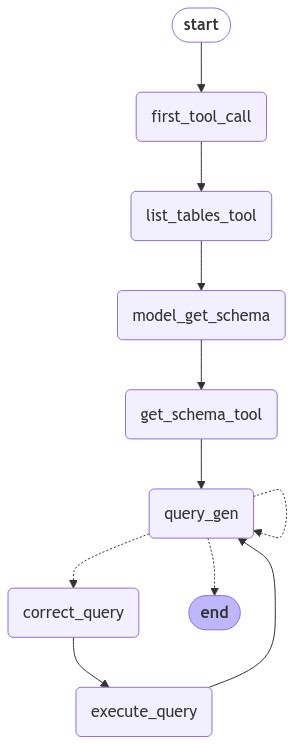

In [19]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass


### 运行 Agent


In [20]:
query = "Which sales agent made the most in sales in 2009?"

events = app.stream(
    {"messages": [("user", query)]},
    stream_mode="values"  # stream_mode 设置为 "values"，表示返回流式数据的值
)

# 遍历每个事件，并打印最后一条消息的内容
for event in events:
    # 通过 pretty_print 打印最后一条消息的内容
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Which sales agent made the most in sales in 2009?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (sql_list_tables)
 Call ID: sql_list_tables
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_jqdtZvplscKL8WFOH4Qi20ge)
 Call ID: call_jqdtZvplscKL8WFOH4Qi20ge
  Args:
    table_names: Employee, Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Employee" (
	"EmployeeId" INTEGER NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"FirstName" NVARCHAR(20) NOT NULL, 
	"Title" NVARCHAR(30), 
	"Repo